<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [17]:
!python --version

Python 3.9.16


In [18]:
import time
import os
import sys
import pandas as pd
import numpy as np
import json
from itertools import product
from .pyjedai.utils import to_path
from .pyjedai.datamodel import Data
from .pyjedai.workflow import ProgressiveWorkFlow
from .pyjedai.utils import values_given, get_multiples, necessary_dfs_supplied, store_workflow_results, pretty_print_workflow
from .pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking)
                                   
from .pyjedai.block_cleaning import (
    BlockFiltering,
    BlockPurging)                         
from .pyjedai.comparison_cleaning import (
    WeightedEdgePruning, 
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning, 
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation)                                   
from .pyjedai.prioritization import (
    GlobalTopPM, 
    LocalTopPM, 
    EmbeddingsNNBPM, 
    GlobalPSNM, 
    LocalPSNM, 
    PESM, 
    WhooshPM,
    class_references)
from .pyjedai.evaluation import Evaluation

#-EDIT-THOSE-#

# parameters native to the pyjedai progressive workflow
# don't edit, unless new parameters were added to the workflow
VALID_WORKFLOW_PARAMETERS = ['matcher',
                            'algorithm',
                            'number_of_nearest_neighbors',
                            'indexing',
                            'similarity_function',
                            'language_model',
                            'tokenizer',
                            'weighting_scheme',
                            'window_size']
# path of the configuration file
CONFIG_FILE_PATH = to_path('~/pyJedAI/pyJedAI-Dev/script-configs/per_experiments.json')
# which configuration from the json file should be used in current experiment  
EXPERIMENT_NAME = 'vector-based-debug-test'
# path at which the results will be stored within a json file
RESULTS_STORE_PATH = to_path('~/pyJedAI/pyJedAI-Dev/scirpts-results/' + EXPERIMENT_NAME + '.json')
# results should be stored in the predefined path
STORE_RESULTS = True
# AUC calculation and ROC visualization after execution
VISUALIZE_RESULTS = True
# workflow arguments and execution info should be printed in terminal once executed
PRINT_WORKFLOWS = True
# identifier column names for source and target datasets
D1_ID = 'id'
D2_ID = 'id'

##############                          
                                   
with open(CONFIG_FILE_PATH) as file:
    config = json.load(file)
    
config = config[EXPERIMENT_NAME]
workflow_config = {k: v for k, v in config.items() if(values_given(config, k) and k in VALID_WORKFLOW_PARAMETERS)}
workflow_parameters = list(workflow_config.keys())
workflow_values = list(workflow_config.values())
workflow_combinations = list(product(*workflow_values))

if(not necessary_dfs_supplied(config)):
    raise ValueError("Different number of source, target dataset and ground truth paths!")

datasets_info = list(zip(config['source_dataset_path'], config['target_dataset_path'], config['ground_truth_path']))


results = dict()
execution_count : int = 0

for id, dataset_info in enumerate(datasets_info):
    dataset_id = id + 1
    d1_path, d2_path, gt_path = dataset_info
    dataset_name = config['dataset_name'][id] if(values_given(config, 'dataset_name') and len(config['dataset_name']) > id) else ("D" + str(dataset_id))
    
    d1 = pd.read_csv(to_path(d1_path), sep='|', engine='python', na_filter=False).astype(str)
    d2 = pd.read_csv(to_path(d2_path), sep='|', engine='python', na_filter=False).astype(str)
    gt = pd.read_csv(to_path(gt_path), sep='|', engine='python')

    d1_attributes = config['d1_attributes'][id] if values_given(config, 'd1_attributes') else d1.columns.tolist()
    d2_attributes = config['d2_attributes'][id] if values_given(config, 'd2_attributes') else d2.columns.tolist()

    data = Data(
        dataset_1=d1,
        attributes_1=['id','name','description'],
        id_column_name_1=D1_ID,
        dataset_2=d2,
        attributes_2=['id','name','description'],
        id_column_name_2=D2_ID,
        ground_truth=gt,
    )
    
    true_positives_number = len(gt)
    budgets = config['budget'] if values_given(config, 'budget') else get_multiples(true_positives_number, 10)
        
    for budget in budgets:
        for workflow_combination in workflow_combinations:
            workflow_arguments = dict(zip(workflow_parameters, workflow_combination))
            workflow_arguments['budget'] = budget
            workflow_arguments['dataset'] = dataset_name
            

            print(f"#### WORKFLOW {execution_count} ####")
            current_workflow = ProgressiveWorkFlow()
            current_workflow.run(data=data, **workflow_arguments)            
            current_workflow_info : dict =  store_workflow_results(results=results,current_workflow=current_workflow,workflow_arguments=workflow_arguments)
            execution_count += 1
            
            if(PRINT_WORKFLOWS):
                pretty_print_workflow(current_workflow_info)
            
evaluator = Evaluation(data)
if(VISUALIZE_RESULTS):
    evaluator.visualize_results_roc(results=results)        
                     
if(STORE_RESULTS):
    with open(RESULTS_STORE_PATH, 'w') as file:
        json.dump(results, file, indent=4)  

ImportError: attempted relative import with no known parent package

In [2]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("../data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("../data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("../data/ccer/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Block Building

In [3]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
qgb = QGramsBlocking(qgrams=6)
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Q-Grams Blocking: 100%|██████████| 2152/2152 [00:00<00:00, 24119.24it/s]


In [5]:
qgb.evaluate(blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Q-Grams Blocking
***************************************************************************************************************************
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 6
Runtime: 0.0900 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      0.32% 
	Recall:        99.91%
	F1-score:       0.63%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1075
	False positives: 337743
	True negatives: 820032
	False negatives: 1
	Total comparisons: 338818
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 0.3172794833804579,
 'Recall %': 99.90706319702602,
 'F1 %': 0.6325501479873138,
 'True Positives': 1075,
 'False Positives': 337743,
 'True Negatives': 820032,
 'False Negatives': 1}

# Block Cleaning

In [6]:
from pyjedai.block_cleaning import BlockFiltering

In [7]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering: 100%|██████████| 3/3 [00:00<00:00, 63.43it/s]


# Comparison Cleaning


In [8]:
from pyjedai.block_cleaning import BlockPurging

In [9]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging: 100%|██████████| 6216/6216 [00:00<00:00, 436750.04it/s]


In [10]:
cbbp.evaluate(cleaned_blocks, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Block Purging
***************************************************************************************************************************
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 2491.0
Runtime: 0.0152 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      1.13% 
	Recall:        99.54%
	F1-score:       2.24%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 1071
	False positives: 93348
	True negatives: 1064423
	False negatives: 5
	Total comparisons: 94419
─────────────────────────────────────────────────────────────────────────────────────────────

{'Precision %': 1.1343055952721381,
 'Recall %': 99.53531598513011,
 'F1 %': 2.2430493743127915,
 'True Positives': 1071,
 'False Positives': 93348,
 'True Negatives': 1064423,
 'False Negatives': 5}

# Progressive Entity Matching

Applies Entity Matching to a subset of candidate pairs based on prioritization scheme.

In [11]:
from pyjedai.prioritization import (
    GlobalTopPM,
    LocalTopPM,
    EmbeddingsNNBPM,
    GlobalPSNM,
    LocalPSNM,
    RandomPM,
    PESM,
    WhooshPM
)

In [12]:
%%time
inorder_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

inorder_ltpm_pairs = inorder_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='inorder', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1.11 s, sys: 19.1 ms, total: 1.13 s
Wall time: 1.12 s


In [29]:
%%time
reverse_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

reverse_ltpm_pairs = reverse_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='reverse', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [30]:
%%time
bilateral_ltpm = LocalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

bilateral_ltpm_pairs = bilateral_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='bilateral', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s


In [47]:
%%time
gtpm = GlobalTopPM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    number_of_nearest_neighbors=10,
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

bilateral_ltpm_pairs = bilateral_ltpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', indexing='inorder', tqdm_disable=True, emit_all_tps_stop=False)

TypeError: __init__() got an unexpected keyword argument 'w_scheme'

In [15]:
%%time
gpsnm = GlobalPSNM(
    weighting_scheme = 'ID',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

gpsnm_pairs_graph = gpsnm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'GlobalPSNM' is not defined

In [16]:
%%time
lpsnm = LocalPSNM(
    weighting_scheme = 'ID',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

lpsnm_pairs_graph = lpsnm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'LocalPSNM' is not defined

In [17]:
%%time
ennbpm = EmbeddingsNNBPM(
    language model = 'sminilm',
    similarity_search = 'faiss',
    similarity_function = 'dice',
    tokenizer = 'white_space_tokenizer',
    similarity_threshold = 0.1
)
ennbpm_pairs_graph = ennbpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'EmbeddingsNNBPM' is not defined

In [18]:
%%time
rpm = RandomPM(
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

rpm_pairs_graph = rpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

NameError: name 'RandomPM' is not defined

In [221]:
%%time
pesm = PESM(
    weighting_scheme = 'X2',
    similarity_function='dice',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

pesm_pairs_graph = pesm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

CPU times: user 5.28 s, sys: 7.93 ms, total: 5.29 s
Wall time: 5.29 s


In [225]:
%%time
whpm = WhooshPM(
    similarity_function='TF-IDF',
    similarity_threshold=0.1,
    attributes = ['description', 'name']
)

whpm_graph = whpm.predict(data, cleaned_blocks, budget = 5000, algorithm='HB', tqdm_disable=True, emit_all_tps_stop=False)

Applying TF-IDF Similarity Function
CPU times: user 7.47 s, sys: 35.9 ms, total: 7.51 s
Wall time: 7.55 s


In [20]:
matchers_data = []

# matchers_data.append(("Random", rpm))
# matchers_data.append(("Local Top", ltpm))
# matchers_data.append(("Global Top", gtpm))
# matchers_data.append(("GSN", gpsnm))
# matchers_data.append(("ES-BFS", pesm))
# matchers_data.append(("ENNBPM-HB", ennbpm))
# matchers_data.append(("WHOOSH-BFS", whpm))
matchers_data.append(("Inorder LTPM", inorder_ltpm))
matchers_data.append(("Reverse LTPM", test_workflow.progressive_matcher))
# matchers_data.append(("Bilateral LTPM", bilateral_ltpm))


TPS checked: None
TPS checked: None


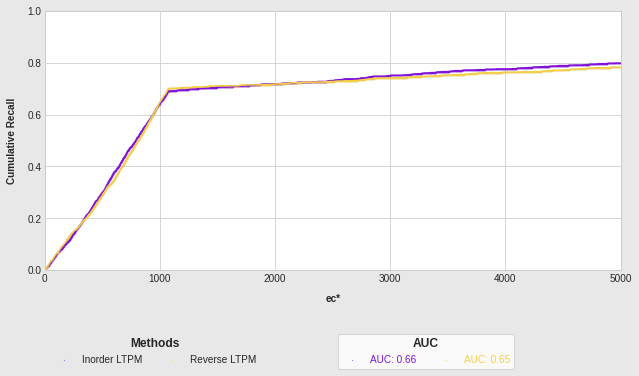

CPU times: user 125 ms, sys: 104 ms, total: 229 ms
Wall time: 110 ms


In [21]:
%%time
progressive_matchers_evaluator = Evaluation(data)
progressive_matchers_evaluator.evaluate_auc_roc(matchers_data = matchers_data, proportional = False)

In [18]:
from pyjedai.workflow import ProgressiveWorkFlow

test_workflow = ProgressiveWorkFlow()
test_workflow.run(matcher=LocalTopPM, algorithm='HB', data=data, number_of_nearest_neighbors=10, indexing='reverse', similarity_function='dice')

Global Top Progressive Matching (dice):   0%|          | 0/3019 [09:21<?, ?it/s]

{'similarity_function': 'dice', 'number_of_nearest_neighbors': 10}
{'indexing': 'reverse'}



Global Top Progressive Matching (dice):   0%|          | 0/3019 [00:09<?, ?it/s]


In [ ]:
test_workflow._progr

In [15]:
# After supplying the progressive matchers to AUC ROC evaluation
# You can easily retrieve information about the method's performance using corresponding functions
# You can get the total number of emissions, the final cumulative recall and the normalized AUC

# Example for Entity Scheduling with BFS Method:
print(f'Total Emissions: {pesm.get_total_emissions()}')
print(f'Cumulative Recall: {pesm.get_cumulative_recall()}')
print(f'Normalized AUC: {pesm.get_normalized_auc()}')

NameError: name 'pesm' is not defined

In [18]:
print(f'Total Emissions: {ennbpm.get_total_emissions()}')
print(f'Cumulative Recall: {ennbpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ennbpm.get_normalized_auc()}')

Total Emissions: 106443
Cumulative Recall: 1.0
Normalized AUC: 0.8425875763167529


In [172]:
print(f'Total Emissions: {ennbpm.get_total_emissions()}')
print(f'Cumulative Recall: {ennbpm.get_cumulative_recall()}')
print(f'Normalized AUC: {ennbpm.get_normalized_auc()}')

Total Emissions: 106117
Cumulative Recall: 0.9990706319702602
Normalized AUC: 0.8208217202276312


In [6]:
from pyjedai.workflow import ProgressiveWorkFlow

SyntaxError: invalid syntax (workflow.py, line 362)